# Consuming a Machine Learning Model

**Before going forward check that the server from part 1 is still running.**

In this notebook you will code a minimal client that uses Python's `requests` library to interact with your running server.

In [1]:
import os
import io
import cv2
import requests
import numpy as np
from IPython.display import Image, display

## Understanding the URL


### Breaking down the URL

After experimenting with the fastAPI's client you may have noticed that we made all requests by pointing to a  specific URL and appending some parameters to it.

More concretely:

1. The server is hosted in the URL [http://localhost:8000/](http://localhost:8000/).
2. The endpoint that serves your model is the `/predict` endpoint.

Also you can specify the model to use:  `yolov3` or`yolov3-tiny`. Let's stick to the tiny version for computational efficiency.

Let's get started by putting in place all this information.

In [2]:
base_url = 'http://localhost:8000'
endpoint = '/predict'
model = 'yolov3-tiny'

To consume your model, you append the endpoint to the base URL to get the full URL. Notice that the parameters are absent for now.

In [4]:
url_with_endpoint_no_params = base_url + endpoint
url_with_endpoint_no_params

'http://localhost:8000/predict'

To set any of the expected parameters, the syntax is to add a "?" character followed by the name of the parameter and its value.

Let's do it and check how the final URL looks like:

In [5]:
full_url = url_with_endpoint_no_params + "?model=" + model
full_url

'http://localhost:8000/predict?model=yolov3-tiny'

This endpoint expects both a model's name and an image. But since the image is more complex it is not passed within the URL. Instead we leverage the `requests` library to handle this process.

# Sending a request to your server

### Coding the response_from_server function

As a reminder,  this endpoint expects a POST HTTP request. The `post` function is part of the requests library. 

To pass the file along with the request, you need to create a dictionary indicating the name of the file ('file' in this case) and the actual file.

 `status code` is a handy command to check the status of the response the request triggered. **A status code of 200 means that everything went well.**

In [6]:
def response_from_server(url, image_file, verbose=True):
    """Makes a POST request to the server and returns the response.

    Args:
        url (str): URL that the request is sent to.
        image_file (_io.BufferedReader): File to upload, should be an image.
        verbose (bool): True if the status of the response should be printed. False otherwise.

    Returns:
        requests.models.Response: Response from the server.
    """
    
    files = {'file': image_file}
    response = requests.post(url, files=files)
    status_code = response.status_code
    if verbose:
        msg = "Everything went well!" if status_code == 200 else "There was an error when handling the request."
        print(msg)
    return response

To test this function, open a file in your filesystem and pass it as a parameter alongside the URL:

In [8]:
with open("images/clock2.jpg", "rb") as image_file:
    prediction = response_from_server(full_url, image_file)

Everything went well!


Great news! The request was successful. However, you are not getting any information about the objects in the image.

To get the image with the bounding boxes and labels,  you need to parse the content of the response into an appropriate format. This process looks very similar to how you read raw images into a cv2 image on the server.

To handle this step, let's create a directory called `images_predicted` to save the image to:

In [9]:
dir_name = "images_predicted"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)


### Creating the display_image_from_response function

In [10]:
def display_image_from_response(response):
    """Display image within server's response.

    Args:
        response (requests.models.Response): The response from the server after object detection.
    """
    
    image_stream = io.BytesIO(response.content)
    image_stream.seek(0)
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    filename = "image_with_objects.jpeg"
    cv2.imwrite(f'images_predicted/{filename}', image)
    display(Image(f'images_predicted/{filename}'))

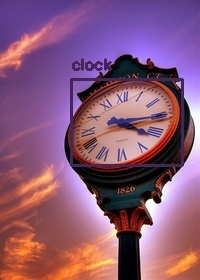

In [11]:
display_image_from_response(prediction)

Now you are ready to consume your object detection model through your own client!

Let's test it out on some other images:

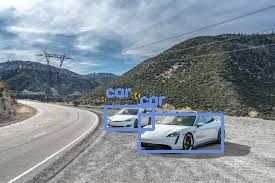

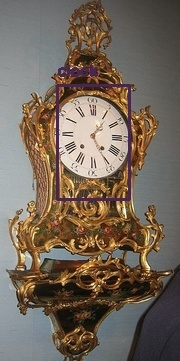

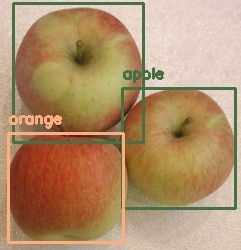

In [12]:
image_files = [
    'car2.jpg',
    'clock3.jpg',
    'apples.jpg'
]

for image_file in image_files:
    with open(f"images/{image_file}", "rb") as image_file:
        prediction = response_from_server(full_url, image_file, verbose=False)
    
    display_image_from_response(prediction)

Real life clients and servers have a lot more going on in terms of security and performance. However, the code you just experienced is close to what you see in real production environments. 
Hopefully, this lab served the purpose of increasing your familiarity with the process of deploying a Deep Learning model, and consuming from it.

# 
## Optional Challenge - Adding the confidence level to the request

Let's expand on what you have learned so far. The next logical step is to extend the server and the client so that they can accommodate an additional parameter: the level of confidence of the prediction. 

**To test your extended implementation you must perform the following steps:**

- Stop the server by interrupting the Kernel.
- Extend the `prediction` function in the server.
- Re run the cell containing your server code.
- Re launch the server.
- Extend your client.
- Test it with some images (either with your client or fastAPI's one).

Here are some hints that can help you out throughout the process:

#### Server side:
- The `prediction` function that handles the `/predict` endpoint needs an additional parameter to accept the confidence level. Add this new parameter before the `File` parameter. This is necessary because `File` has a default value and must be specified last.


- `cv.detect_common_objects` accepts the `confidence` parameter, which is a floating point number (type `float`in Python).


#### Client side:
- You can add a new parameter to the URL by extending it with an `&` followed by the name of the parameter and its value. The name of this new parameter must be equal to the name used within the `prediction` function in the server. An example would look like this: `myawesomemodel.com/predict?model=yolov3-tiny&newParam=value` 